# Canopy RT module (rewrite from mSCOPE)
---
### Can use different leaf properties per layer, but can be boiled down to a simpler version as well. Some examples shown here.
---
To be looked at here:
Computer leaf optical properties for standard values
Compute canopy radiation (both reflectance as well as within canopy distributions for SW energy balance).


In [1]:
# Add PATH (adapt!)
push!(LOAD_PATH, "/Volumes/cfranken/code/gitHub/LSM-SPAM/src/Leaf/");
push!(LOAD_PATH, "/Volumes/cfranken/code/gitHub/LSM-SPAM/src/Utils/");
#push!(LOAD_PATH, "/Volumes/cfranken/code/gitHub/LSM-SPAM/src/tools/");

# Use Plots:
using Plots
#using PhotoStructs
#plotly()

In [2]:
using CanopyRTMod
using BenchmarkTools
using Statistics

In [4]:
wl = CanopyRTMod.wl;
wle = CanopyRTMod.wle;
wlf = CanopyRTMod.wlf;

---
Define the different leaf properties per layer in an array of leaves, can be simplified later if we want to. Right now, I just re-use the same leaf everywhere

In [5]:
arrayOfLeaves = Array{leafbio{FT}, 1}(undef, CanopyRTMod.canopy.nlayers)
for i = 1:CanopyRTMod.canopy.nlayers
    arrayOfLeaves[i] = leafbio{FT, length(wl), length(wle), length(wlf)}()
    CanopyRTMod.fluspect!(arrayOfLeaves[i], CanopyRTMod.optis)
end
# This actually almost takes 1ms!
#CanopyRTMod.fluspect!(leaf, CanopyRTMod.optis)


In [6]:
leaf.fqe=0.0
CanopyRTMod.fluspect!(leaf, CanopyRTMod.optis)

---
## Perform 4 separate steps towards canopy SW RT

#### Compute canopy geometric properties (entirely dependent on LAI and leaf angular distributions)

In [7]:
@btime CanopyRTMod.computeCanopyGeomProps!(canopy, angles,canOpt)

  81.679 μs (543 allocations: 26.64 KiB)


#### Compute layer optical properties (includes leaf reflectance and transmittance now)

In [8]:
@btime CanopyRTMod.computeCanopyMatrices!(arrayOfLeaves,canOpt);

  22.112 μs (0 allocations: 0 bytes)


#### Compute SW radiation transfer via mSCOPE approach

In [9]:
CanopyRTMod.RTM_SW!(canopy, canOpt, canRad,sunRad, CanopyRTMod.soil);

#### Compute all derived fluxes necessary for Photosynthesis and radiation balance 

In [10]:
@btime CanopyRTMod.deriveCanopyFluxes!(canopy, canOpt, canRad,sunRad, CanopyRTMod.soil);

  170.432 μs (1792 allocations: 758.58 KiB)


## Canopy albedos
need to still check whether directional is ok, looks a bit low.

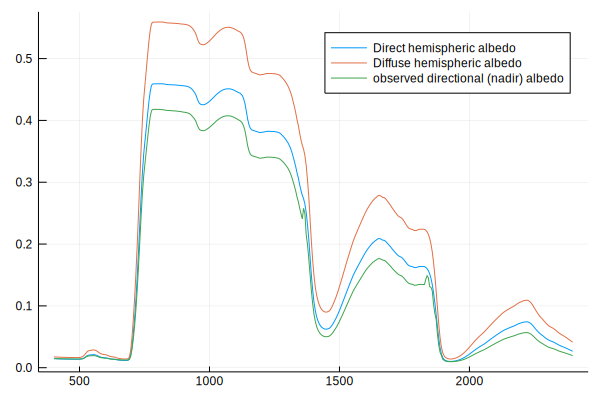

In [11]:
plot(wl,canRad.alb_direct, label="Direct hemispheric albedo")
plot!(wl,canRad.alb_diffuse, label="Diffuse hemispheric albedo")
plot!(wl,canRad.alb_obs, label="observed directional (nadir) albedo")

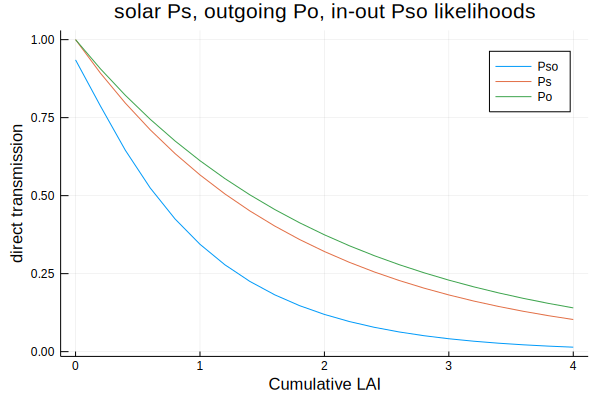

In [12]:
iLAI = canopy.LAI/canopy.nlayers
sumLAI = [0:iLAI:canopy.LAI;]
plot(sumLAI,canOpt.Pso, label="Pso")
plot!(sumLAI,canOpt.Ps, label="Ps")
plot!(sumLAI,canOpt.Po, label="Po")
xlabel!("Cumulative LAI")
ylabel!("direct transmission ")
title!("solar Ps, outgoing Po, in-out Pso likelihoods")

## Energy Balance test
need to check consistency between net TOA radiation and soil+vegetation absorption.

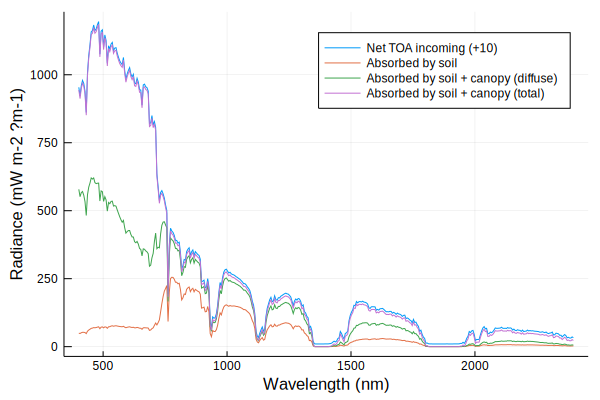

In [13]:
solar_in = sunRad.E_diffuse+sunRad.E_direct;
soil_absorbed = canRad.E_down[:,end]+canOpt.Es_[:,end]-canRad.E_up[:,end]
canopy_absorbed_diff = sum(canRad.netSW_diffuse, dims=2)[:,1]
canopy_absorbed_dir = sum(canRad.netSW_direct, dims=2)[:,1]
plot(wl,solar_in-CanopyRTMod.canRad.E_up[:,1].+10, label="Net TOA incoming (+10)")
plot!(wl,soil_absorbed, label="Absorbed  by soil")
plot!(wl,soil_absorbed+canopy_absorbed_diff, label="Absorbed  by soil + canopy (diffuse)")
plot!(wl,soil_absorbed+canopy_absorbed_diff+canopy_absorbed_dir, label="Absorbed  by soil + canopy (total)")
xlabel!("Wavelength (nm)")
ylabel!("Radiance (mW m-2 μm-1)")

### Energy balance test

In [15]:
sum(soil_absorbed+canopy_absorbed_diff+canopy_absorbed_dir-solar_in+CanopyRTMod.canRad.E_up[:,1], dims=1)

1-element Array{Float32,1}:
 -0.00078478

---
Run Fluspect, leaf optical property generator (provides reflectance and transmittance)

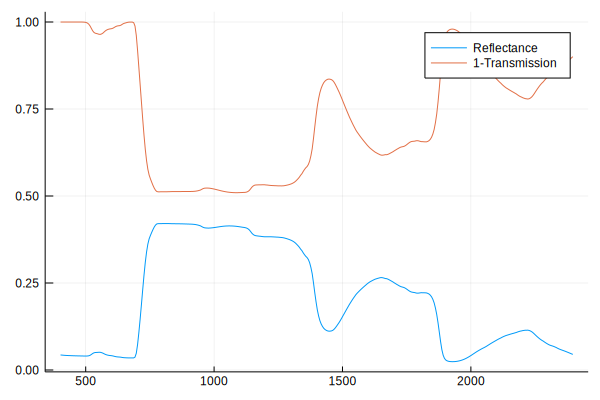

In [16]:
plot(wl, arrayOfLeaves[10].ρ_SW, label="Reflectance")
plot!(wl, 1 .-arrayOfLeaves[10].τ_SW, label="1-Transmission")

In [17]:
println("Net Soil radiation (direct): ", canRad.RnSoil_direct, "W/m2")
println("Net Soil radiation (diffuse): ", canRad.RnSoil_diffuse, "W/m2")

Net Soil radiation (direct): 43.38367W/m2
Net Soil radiation (diffuse): 63.50558W/m2


In [18]:
println("Incoming direct PAR: ", 1e6*canRad.incomingPAR_direct, "moles m^-2 s^-1")
println("Incoming diffuse PAR: ", 1e6*canRad.incomingPAR_diffuse, "moles m^-2 s^-1")

Incoming direct PAR: 1052.2485245019197moles m^-2 s^-1
Incoming diffuse PAR: 582.7956483699381moles m^-2 s^-1


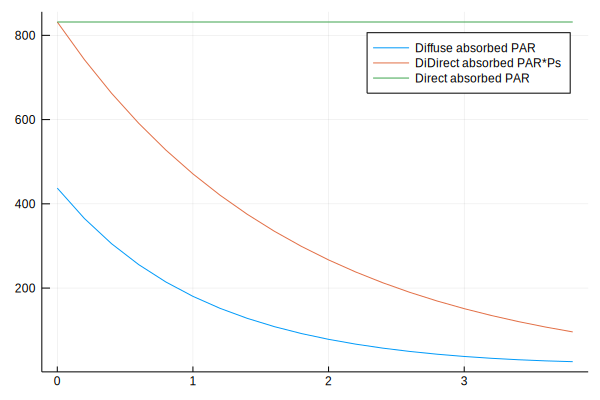

In [27]:
nl = CanopyRTMod.canopy.nlayers
#normi = 1/mean(canOpt.fs'*canopy.lidf)
plot(sumLAI[1:nl], 1e6*canRad.absPAR_shadeCab, label="Diffuse absorbed PAR")
plot!(sumLAI[1:nl], 1e6*canRad.absPAR_sunCab[5,4,:].*canOpt.Ps[1:nl], label="Direct absorbed PAR*Ps")
plot!(sumLAI[1:nl], 1e6*canRad.absPAR_sunCab[5,4,:], label="Direct absorbed PAR")

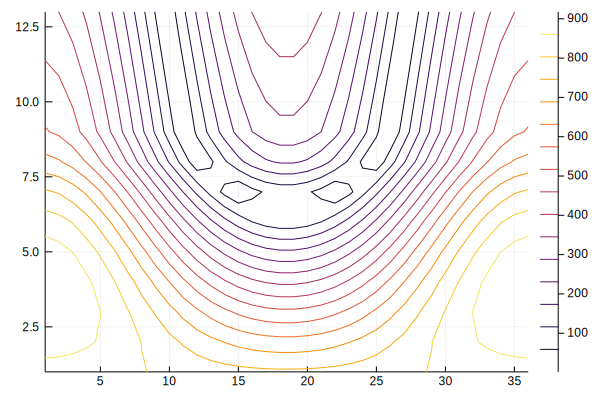

In [28]:
contour(1e6*canRad.absPAR_sunCab[:,:,1])

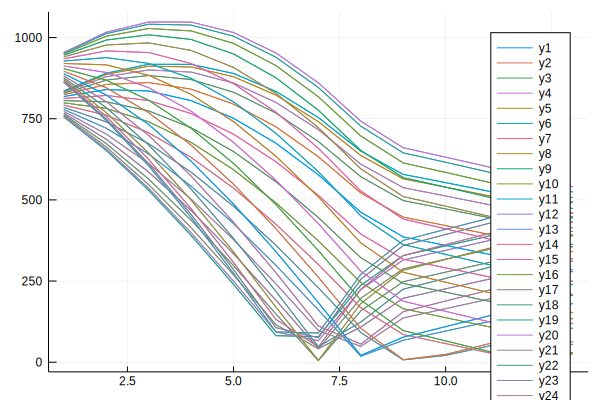

In [23]:
plot(1e6*canRad.absPAR_sunCab[:,:,1])
plot!(1e6*canRad.absPAR_sun[:,:,1])

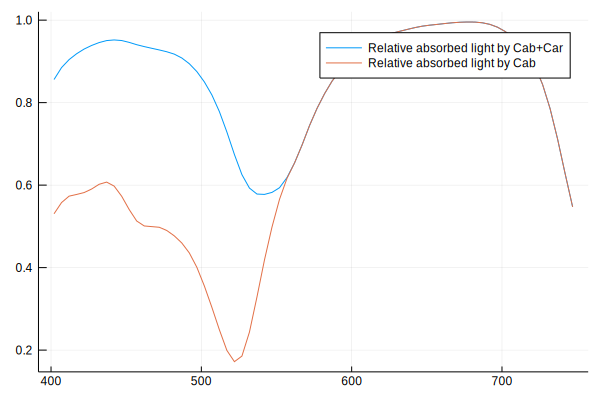

In [24]:

plot(wl[CanopyRTMod.iPAR], leaf.kChlrel[CanopyRTMod.iPAR], label="Relative absorbed light by Cab+Car")
plot!(wl[CanopyRTMod.iPAR], leaf.kChlrel_old[CanopyRTMod.iPAR], label="Relative absorbed light by Cab")